In [2]:
!pip install PyPDF2 nltk scikit-learn matplotlib
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\E-TIME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\E-TIME\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import PyPDF2
import re
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import rand_score
import os
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score



In [4]:
def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        for page in pdf_reader.pages:
            text += page.extract_text()
    return text

In [5]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization using NLTK
    words = nltk.word_tokenize(text)

    # Stopwords removal
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word.lower() not in stop_words]

    return ' '.join(words)

In [6]:
def create_text_chunks(text, chunk_size=512):
    words = text.split()
    chunks = []
    current_chunk = []

    for word in words:
        current_chunk.append(word)
        if len(current_chunk) >= chunk_size:
            chunks.append(' '.join(current_chunk))
            current_chunk = []

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks

In [7]:
def extract_tfidf_vectors(chunks):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(chunks)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    return tfidf_matrix, feature_names

In [8]:
def get_text(works):
  texts=[]
  labels=[]
  for author,paths in works.items():
    if(isinstance(paths,list)):
      for path in paths:
        text = extract_text_from_pdf(path)
        preprocessed_text = preprocess_text(text)
        chunks = create_text_chunks(preprocessed_text, chunk_size=512)
        texts.extend(chunks)
        labels.extend([author]*len(chunks))
    else:
      text = extract_text_from_pdf(paths)
      preprocessed_text = preprocess_text(text)
      chunks = create_text_chunks(preprocessed_text, chunk_size=512)
      texts.extend(chunks)
      labels.extend([author]*len(chunks))
  return texts,labels

In [11]:
authors = {
    'Abdulhak Sinasi Hisar':[
        'Abdulhak Sinasi Hisar\Ali Nizami Beyin Alafrangaligi ve Seyhligi.pdf',
        'Abdulhak Sinasi Hisar\Camlicadaki Enistemiz.pdf',
        'Abdulhak Sinasi Hisar\Fahim Bey ve Biz.pdf',
    ],
    'Ahmet Hamdi Tanpinar':[
      'Ahmet Hamdi Tanpinar\Huzur.pdf',
      'Ahmet Hamdi Tanpinar\Mahur Beste.pdf',
      'Ahmet Hamdi Tanpinar\Sahnenin Disindakiler.pdf',
    ],
    'Halid Ziya Usakligil':[
      'Halid Ziya Usakligil\Ask-i Memnu.pdf',
      'Halid Ziya Usakligil\Kadin Pencesi.pdf',
      'Halid Ziya Usakligil\Kirik Hayatlar.pdf',
    ],
    'Refik Halid Karay':[
      'Refik Halid Karay\Anahtar.pdf',
      'Refik Halid Karay\Bu Bizim Hayatimiz.pdf',
      'Refik Halid Karay\Bugunun Saraylisi.pdf'
    ],
}

ali_teoman={
  'Karadelik Güncesi':'Ali Teoman\Ali Teoman - Karadelik Güncesi.pdf',
  'Gizli Kalmis Istanbul Masali':'Ali Teoman\GizliKalmisIstanbulMasali.pdf',  
  'insansiz Konak':'Ali Teoman\insansizKonak061607.pdf',  
}

other_text,others_labels = get_text(authors)
ali_teoman_text,ali_teoman_labels = get_text(ali_teoman)

In [10]:
from sklearn.mixture import GaussianMixture
def k_mean_cluster(no_of_clusters,data):

  model = KMeans(n_clusters=no_of_clusters,init="k-means++",max_iter=100,n_init=1)

  kmean_indices  = model.fit_predict(data)
  return kmean_indices

In [13]:
def calculate_purity(true_labels, predicted_labels, num_clusters):
    # Ensure labels are numpy arrays for indexing operations
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    
    purity = 0
    for cluster in range(num_clusters):
        # Find the most frequent true label in this cluster
        indices = np.where(predicted_labels == cluster)
        if indices[0].size == 0: continue  # Skip empty clusters
        most_common_true_label = Counter(true_labels[indices]).most_common(1)[0][0]
        # Count how many times this label appears in the cluster
        num_most_common = (true_labels[indices] == most_common_true_label).sum()
        # Add the ratio of this count to the total size to the purity
        purity += num_most_common / true_labels.shape[0]
    return purity


In [14]:
other_tfidf_matrix,other_feature_names = extract_tfidf_vectors(other_text)
other_model = KMeans(n_clusters=4,init="k-means++",max_iter=100,n_init=1)
other_model.fit(other_tfidf_matrix)
other_kmean_indices = other_model.fit_predict(other_tfidf_matrix)
other_pca= PCA(n_components=2)
other_points = other_pca.fit_transform(other_tfidf_matrix.toarray())
label_encoder = LabelEncoder()
others_labels = label_encoder.fit_transform(others_labels)
other_purity = calculate_purity(others_labels, other_kmean_indices,4)
other_rand_index = adjusted_rand_score(others_labels, other_kmean_indices)
other_silhouette_score = silhouette_score(others_labels,other_kmean_indices)

ali_teoman_tfidf_matrix,ali_teoman_feature_names = extract_tfidf_vectors(ali_teoman_text)

ali_teoman_model = KMeans(n_clusters=3,init="k-means++",max_iter=100,n_init=1)
ali_teoman_model.fit(ali_teoman_tfidf_matrix)
ali_teoman_kmean_indices = ali_teoman_model.fit_predict(ali_teoman_tfidf_matrix)
ali_teoman_pca= PCA(n_components=2)
ali_teoman_points = ali_teoman_pca.fit_transform(ali_teoman_tfidf_matrix.toarray())
ali_teoman_labels = label_encoder.fit_transform(ali_teoman_labels)
ali_teoman_silhouette_score = silhouette_score(ali_teoman_labels,ali_teoman_kmean_indices)
ali_teoman_purity = calculate_purity(ali_teoman_labels, ali_teoman_kmean_indices,3)
ali_teoman_rand_index = adjusted_rand_score(ali_teoman_labels, ali_teoman_kmean_indices)

# Set up a figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns
ax[0].set_title('Clustering of Other Writers')
ax[0].scatter(other_points[:,0],other_points[:,1],c=other_kmean_indices,cmap='viridis',marker='o',alpha=0.5)
ax[0].legend
ax[0].text(x=0.05, y=0.95, s=f"Rand Index: {other_rand_index:.2f}\nPurity: {other_purity:.2f}\nSilhouette: {other_silhouette_score:.2f}", 
        transform=ax[0].transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))

ax[1].set_title('Clustering of Ali Teoman\'s Works')
ax[1].scatter(ali_teoman_points[:,0],ali_teoman_points[:,1],c=ali_teoman_kmean_indices,cmap='viridis',marker='o',alpha=0.5)
ax[1].legend
ax[1].text(x=0.05, y=0.95, s=f"Rand Index: {ali_teoman_rand_index:.2f}\nPurity: {ali_teoman_purity:.2f}\nSilhouette: {ali_teoman_silhouette_score:.2f}", 
        transform=ax[1].transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))

plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[0 0 0 ... 3 3 3].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [18]:
def contains_directories(directory):
    with os.scandir(directory) as entries:
        for entry in entries:
            if entry.is_dir():
                return True
    return False

In [20]:
def read_vectors(path):
    combined_data=[]
    true_labels = []  
    if contains_directories(path): 
        for author in os.listdir(path):
            author_directory = os.path.join(path,author)
            if os.path.isdir(author_directory):
                for file in os.listdir(author_directory):
                    if file.endswith('.npy'):
                        data = np.load(os.path.join(author_directory,file))
                        combined_data.append(data)
                        true_labels.extend([author]*len(data))
    else:
        for book in os.listdir(path):
            data = np.load(os.path.join(path,book))
            combined_data.append(data)
            true_labels.extend([book]*len(data))
    combined_data = np.vstack(combined_data)
    label_encoder = LabelEncoder()
    true_labels = label_encoder.fit_transform(true_labels)
    return combined_data,true_labels
        
        

In [15]:
def check_result(base_directory,other_n_clusters,ali_teoman_n_clusters):
    other_authors  = os.path.join(base_directory,'Other Authors')
    ali_teoman  = os.path.join(base_directory,'Ali Teoman')
    other_combined_data, other_true_labels = read_vectors(other_authors)
    ali_teoman_combined_data, ali_teoman_true_labels = read_vectors(ali_teoman)
    
    print('original length other authors'+str(len(other_combined_data)))
    other_kmean_indices = k_mean_cluster(other_n_clusters,other_combined_data)
    print('original length ali teoman'+str(len(ali_teoman_combined_data)))
    ali_teoman_kmean_indices = k_mean_cluster(ali_teoman_n_clusters,ali_teoman_combined_data)

    
    other_silhouette_score = silhouette_score(other_true_labels,other_kmean_indices)
    ali_teoman_silhouette_score = silhouette_score(ali_teoman_combined_data,ali_teoman_kmean_indices)
    # Calculate the Rand Index
    other_rand_index = rand_score(other_true_labels, other_kmean_indices)
    ali_teoman_rand_index = rand_score(ali_teoman_true_labels, ali_teoman_kmean_indices)

    # Calculate purity
    other_purity = calculate_purity(other_true_labels, other_kmean_indices,other_n_clusters)
    ali_teoman_purity = calculate_purity(ali_teoman_true_labels, ali_teoman_kmean_indices,ali_teoman_n_clusters)

    other_pca = PCA(n_components=2)
    other_reduced_data = other_pca.fit_transform(other_combined_data)
    ali_teoman_pca = PCA(n_components=2)
    ali_teoman_reduced_data = ali_teoman_pca.fit_transform(ali_teoman_combined_data)

    # Set up a figure with two subplots side by side
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns
    ax[0].set_title('Clustering of Other Writers'+base_directory)
    ax[0].scatter(other_reduced_data[:,0],other_reduced_data[:,1],c=other_kmean_indices,cmap='viridis',marker='o',alpha=0.5)
    ax[0].legend
    ax[0].text(x=0.05, y=0.95, s=f"Rand Index: {other_rand_index:.2f}\nPurity: {other_purity:.2f}\nSilhouette: {other_silhouette_score:.2f}", 
            transform=ax[0].transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))
    
    ax[1].set_title('Clustering of Ali Teoman\'s Works'+base_directory)
    ax[1].scatter(ali_teoman_reduced_data[:,0],ali_teoman_reduced_data[:,1],c=ali_teoman_kmean_indices,cmap='viridis',marker='o',alpha=0.5)
    ax[1].legend
    ax[1].text(x=0.05, y=0.95, s=f"Rand Index: {ali_teoman_rand_index:.2f}\nPurity: {ali_teoman_purity:.2f}\nSilhouette: {ali_teoman_silhouette_score:.2f}", 
            transform=ax[1].transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))
    
    return plt

In [16]:
base_directory = './BERT/chunk_size_32/'
other_n_clusters=4
ali_teoman_n_clusters=3
p = check_result(base_directory,other_n_clusters,ali_teoman_n_clusters)
p.show()

NameError: name 'read_vectors' is not defined

original length other authors11307
original length ali teoman2779


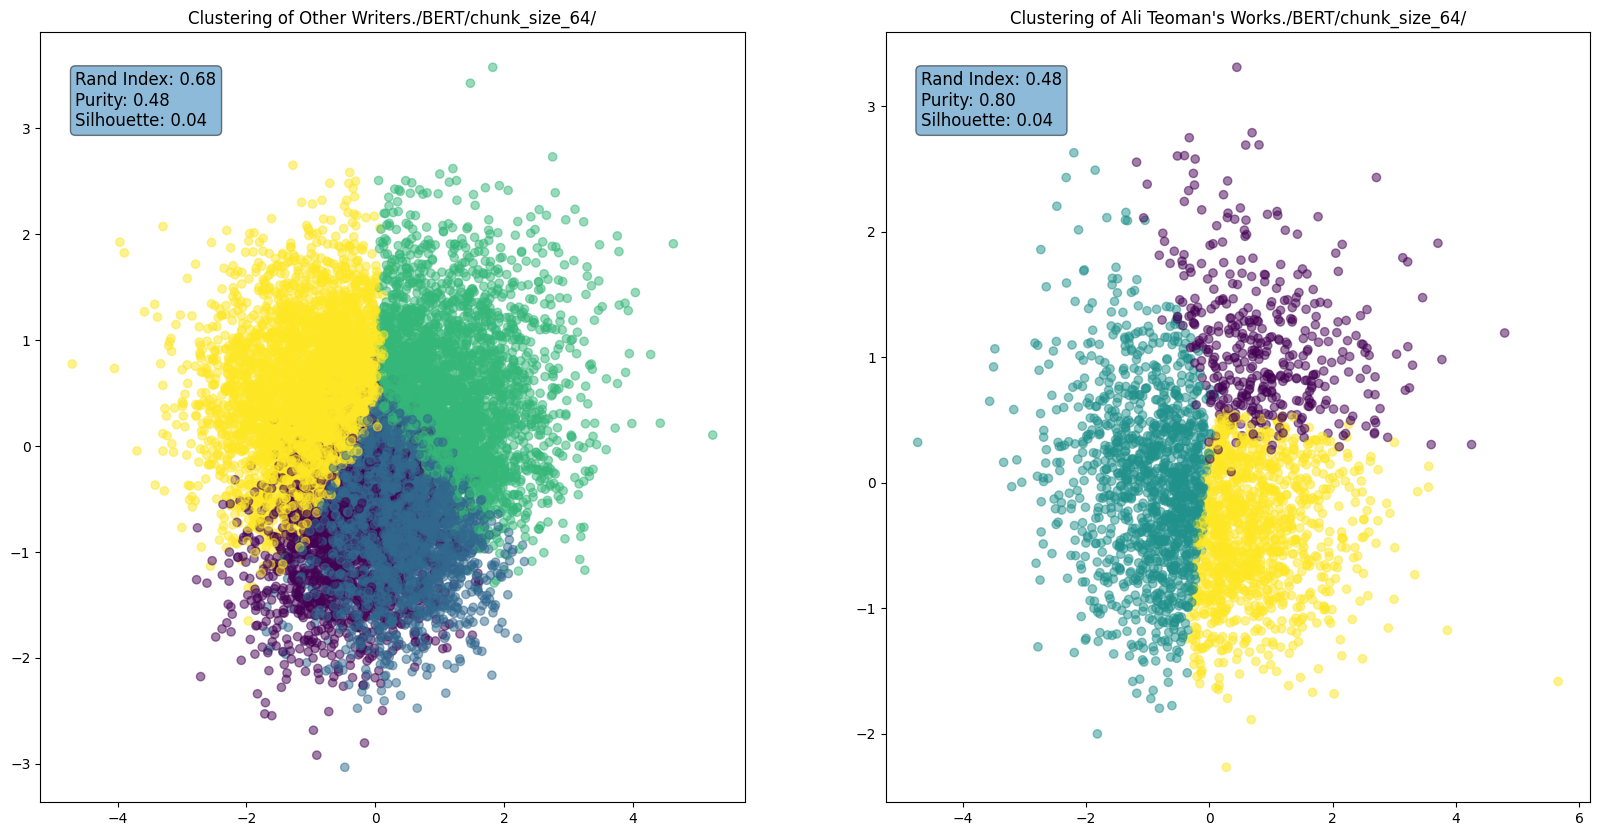

In [19]:
base_directory = './BERT/chunk_size_64/'
other_n_clusters=4
ali_teoman_n_clusters=3
p = check_result(base_directory,other_n_clusters,ali_teoman_n_clusters)
p.show()

In [21]:
base_directory = './BERT/chunk_size_128/'
other_n_clusters=4
ali_teoman_n_clusters=3
p = check_result(base_directory,other_n_clusters,ali_teoman_n_clusters)
p.show()

original length other authors5657
original length ali teoman1390


ValueError: Expected 2D array, got 1D array instead:
array=['Abdulhak Sinasi Hisan' 'Abdulhak Sinasi Hisan' 'Abdulhak Sinasi Hisan'
 ... 'Refik Halid Karay' 'Refik Halid Karay' 'Refik Halid Karay'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

original length other authors22609
original length ali teoman5557


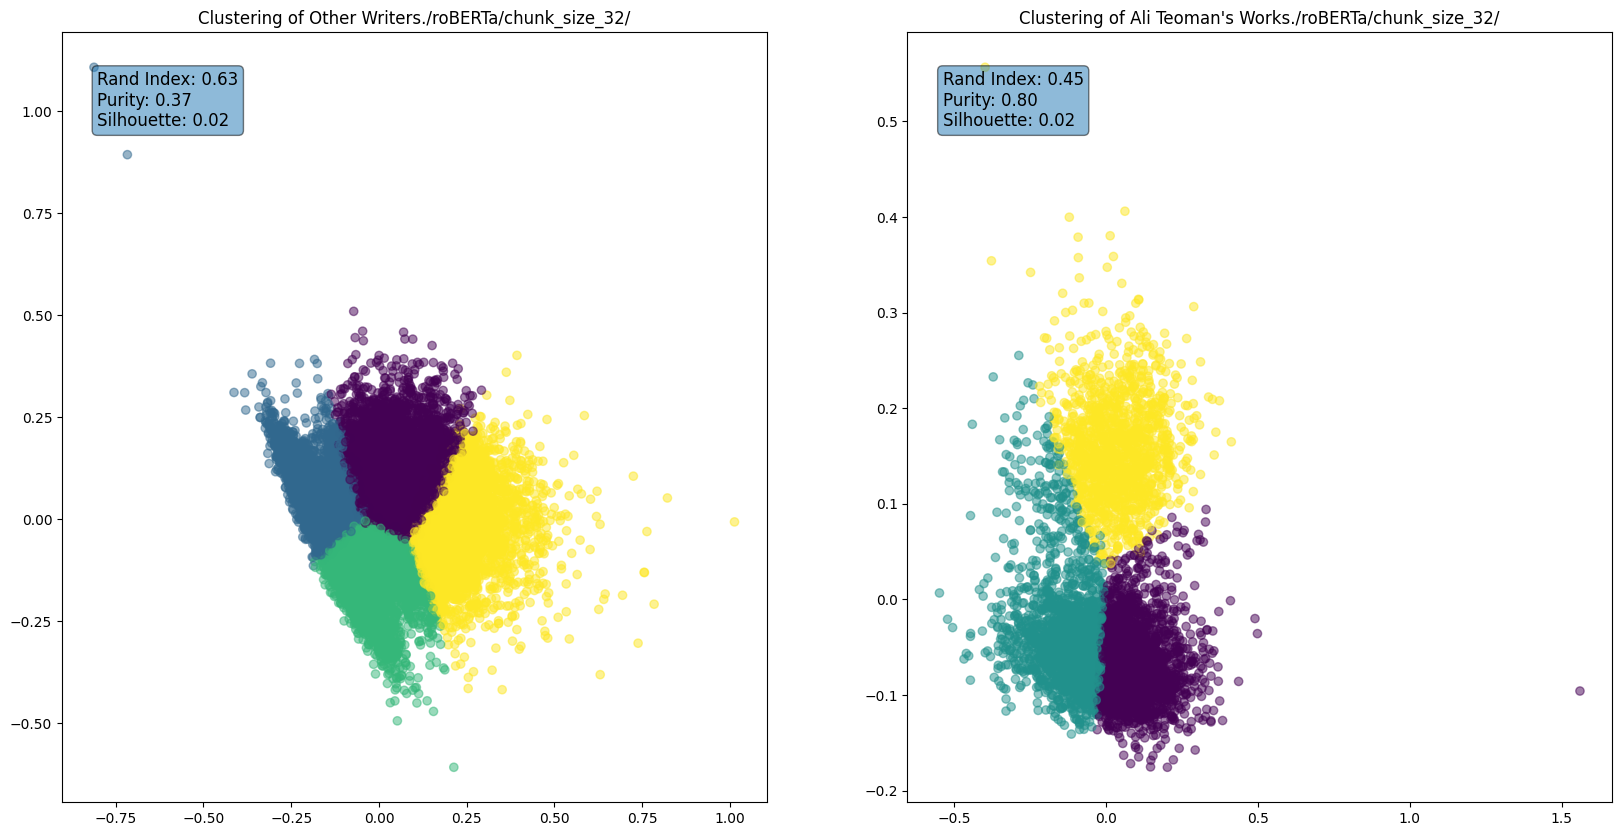

In [22]:
base_directory = './roBERTa/chunk_size_32/'
other_n_clusters=4
ali_teoman_n_clusters=3
p = check_result(base_directory,other_n_clusters,ali_teoman_n_clusters)
p.show()

original length other authors11307
original length ali teoman2779


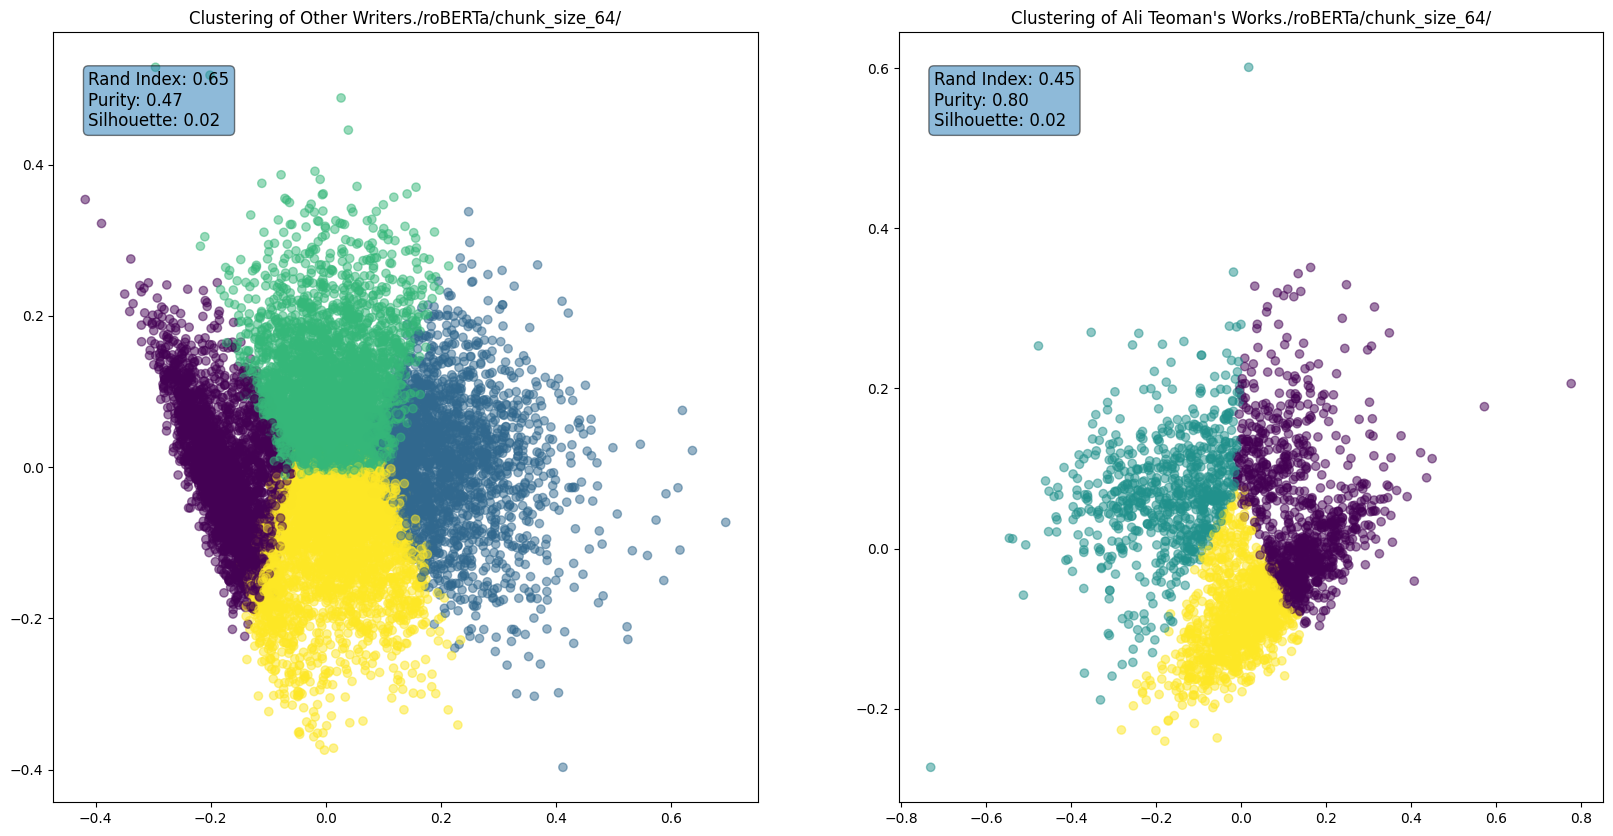

In [25]:
base_directory = './roBERTa/chunk_size_64/'
other_n_clusters=4
ali_teoman_n_clusters=3
p = check_result(base_directory,other_n_clusters,ali_teoman_n_clusters)
p.show()

original length other authors5657
original length ali teoman1390


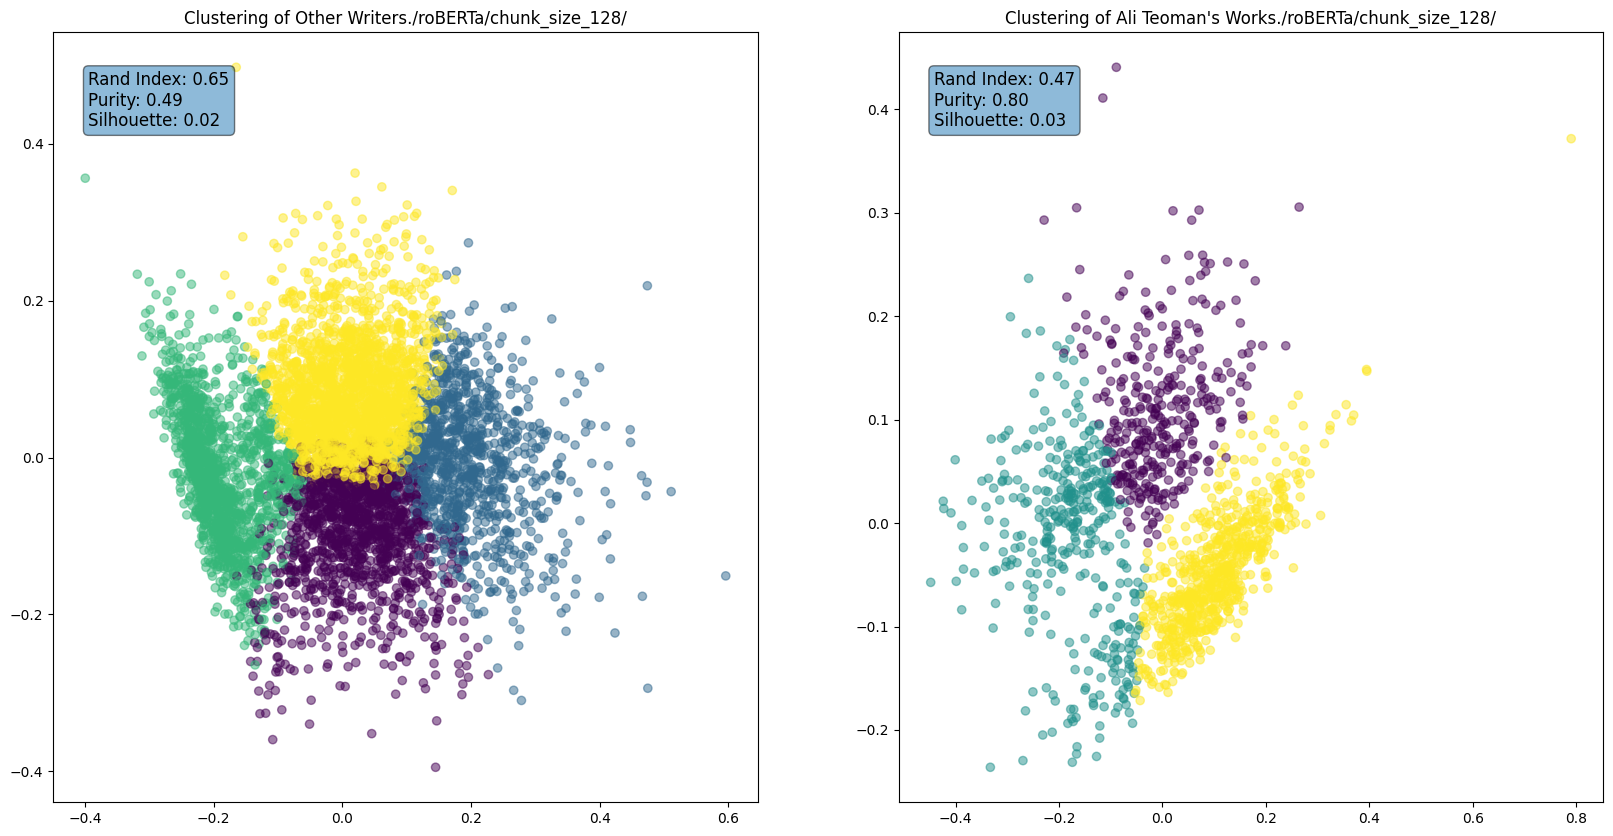

In [26]:
base_directory = './roBERTa/chunk_size_128/'
other_n_clusters=4
ali_teoman_n_clusters=3
p = check_result(base_directory,other_n_clusters,ali_teoman_n_clusters)
p.show()